# Dino Bektesevic Exoplanets HW 3 
March 1st 2019

In [2]:
import rebound
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as c
import copy
from IPython.display import display, clear_output


%matplotlib inline

In [3]:
def newtonsMethod(f, fdot, x, precission=0.01):
    while abs(0-f(x)) > precission:
        x = x - f(x)/fdot(x)
    return x

def keplersEq(E, M, e):
    return E - e*np.sin(E)-M

def keplersEqDot(E, M, e):
    return 1 - e*np.cos(E)
    
def guessE(M, e):
    return M + 0.85*e*np.sign(np.sin(M))

def newtonKeplerSolver(M, e, precission=0.0001):
    E = guessE(M, e)
    f = lambda E: keplersEq(E, M, e)
    fdot = lambda E: keplersEqDot(E, M, e)
    return newtonsMethod(f, fdot, E, precission=precission)

def deg2rad(x):
    return x*np.pi/180

## 1. Familiarize yourself with initializing and running a planetary system

First we define some quantities for our system. I picked GJ 876 to test rebound code on. According to the [manual](https://rebound.readthedocs.io/en/latest/ipython/Units.html) the default units are set such that $G=1$ (i.e. AU, $M_{sun}$, year/$2\pi$ and radians). 

In [4]:
mjup2msun_convert = (c.M_jup/c.M_sun).value
mearth2msun_convert = (c.M_earth/c.M_sun).value

# https://arxiv.org/pdf/1006.4244.pdf
star = {"m":0.334}
planetd = {"m":6.83*mearth2msun_convert, "e":0.20700, "a":0.02080665, "inc":1.02974, "omega":4.08,  "M":6.2}
planetc = {"m":0.7142*mjup2msun_convert, "e":0.25591, "a":0.12959000, "inc":1.02974, "omega":0.851, "M":5.14}
planetb = {"m":2.2756*mjup2msun_convert, "e":0.03240, "a":0.20831700, "inc":1.02974, "omega":0.878, "M":5.68}
planete = {"m":14.6*mearth2msun_convert, "e":0.05500, "a":0.33430000, "inc":1.02974, "omega":4.17,  "M":5.85}

# order matters if inserting through a for loop!
planets = [planetd, planetc, planetb, planete]

Add the planets to the simulation and plot it to see initial state.

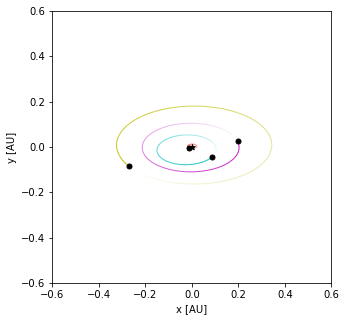

In [5]:
sim = rebound.Simulation()

sim.add(**star)
for planet in planets:
    sim.add(**planet)
sim.move_to_com()

fig = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]",lim=0.6)

Check if integrating the system produces a stable result or if the system seems to be unstable. This is useful to verify that the provided values make sense and are not in the wrong units or that there was a mistake made when converting.

Considering the default unit system used, a single timestep is in reference to $dt=yr/2\pi = 365.256/2\pi = 58.1323$ days. The period of the innermost planet is ~2 days. So a good timestep to use is given as $P/20 ~ 0.1days$ or $0.00172021412dt$. 

A 1000 orbits of the innermost planet takes approximately 2000 days or approximately 5.5 years. Starting from $t=0$ we need to integrate to $t=11\pi$ to get 2000 orbits of closest planet.

In [6]:
a = {'d':[], 'c':[], 'b':[], 'e':[]}
e = {'d':[], 'c':[], 'b':[], 'e':[]}
dt = 0.00172021412

while sim.t<11*np.pi:
    sim.integrate(sim.t+dt)
    for name, particle in zip('dcbe', sim.particles[1:]):
        a[name].append(particle.a)
        e[name].append(particle.e)

Plot the results and verify

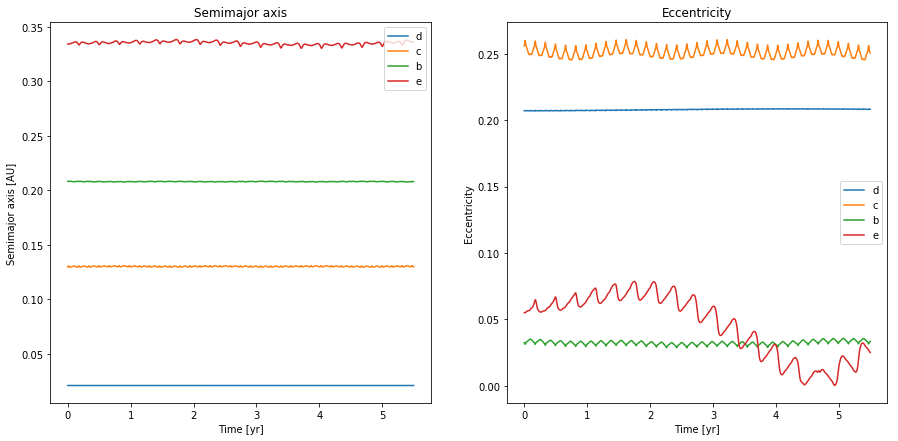

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

t = np.arange(0, sim.t, dt)

for key, val in a.items():
    axes[0].plot(t/(2*np.pi), val, label=key)
axes[0].set_title('Semimajor axis')
axes[0].set_ylabel('Semimajor axis [AU]')
    
for key, val in e.items():
    axes[1].plot(t/(2*np.pi), val, label=key)
axes[1].set_title('Eccentricity') 
axes[1].set_ylabel('Eccentricity')

for ax in axes:
    ax.set_xlabel('Time [yr]')
    ax.legend()

## 2. Look up the parameters of the planet system GJ 876.  Assume the planets’ orbits lie in a plane, and vary the inclination of the system. 

Essentially the above needs to be repeated for a variety of inclinations. Luckily the chosen test system was exactly GJ 876, how fortuitous.

In [22]:
def simulate(planets, dt=0.00172021412, tmax=11*np.pi):
    sim = rebound.Simulation()

    sim.add(**star)
    for planet in planets:
        sim.add(**planet)
    sim.move_to_com()

    a = {'d':[], 'c':[], 'b':[], 'e':[]}
    
    while sim.t<tmax:
        sim.integrate(sim.t+dt)
        for name, particle in zip('dcbe', sim.particles[1:]):
            a[name].append(particle.a)
            
    return a

pplan = planets.copy()
semmajs = []
for i in range(1, 90):
    for planet in pplan:
        planet['inc'] = i
    semmajs.append(simulate(pplan))

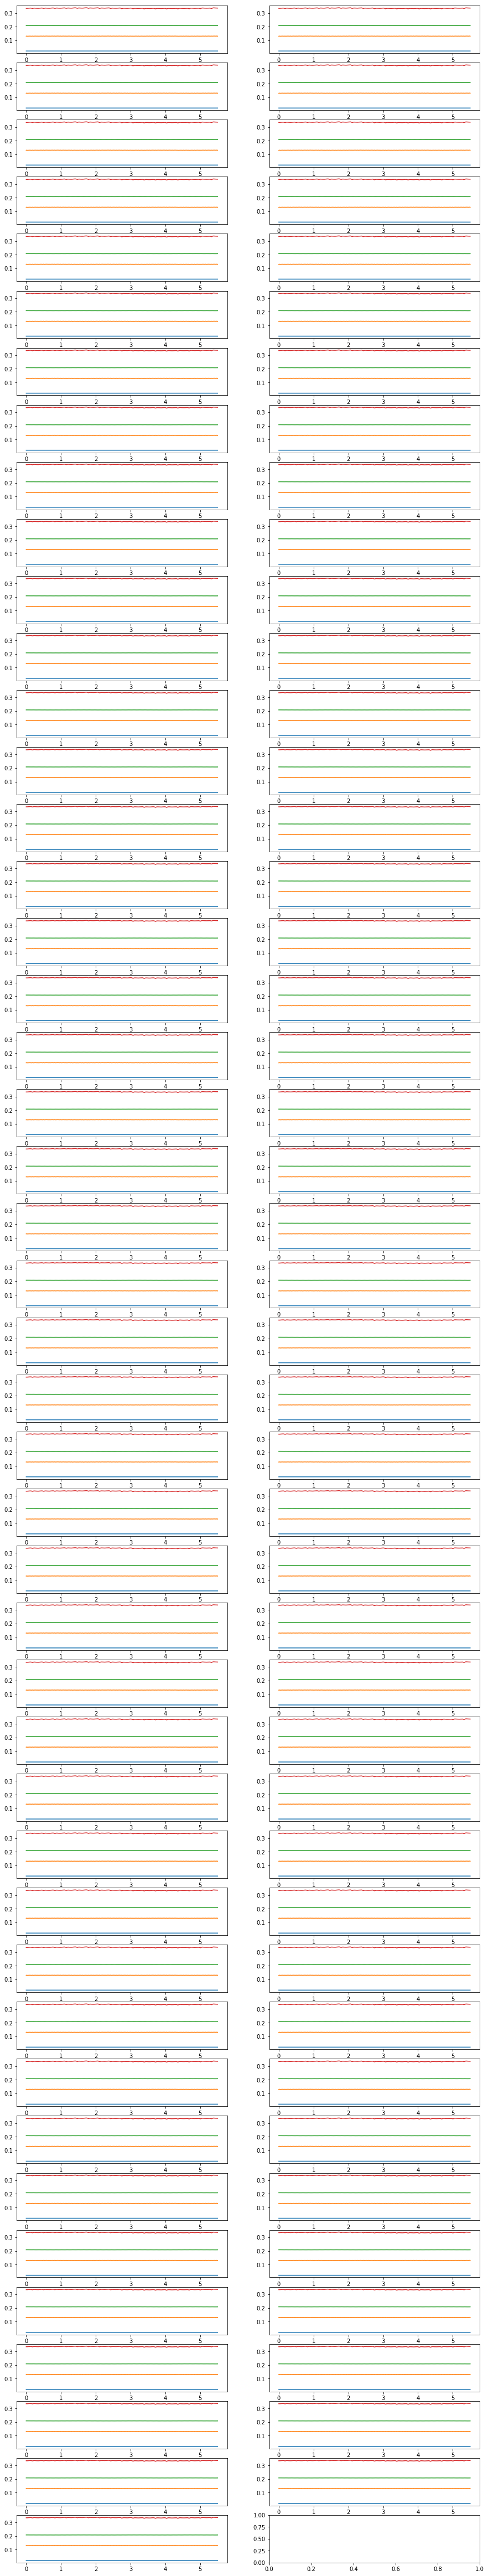

In [25]:
fig, axes = plt.subplots(45, 2, figsize=(15, 85))

for ax, model in zip(axes.flatten(), semmajs):
    for pname, pa in model.items():
        ax.plot(t/(2*np.pi), pa, label=pname)
        

In [11]:
N=100
transittimes = np.zeros(N)
p = sim.particles
i = 0
while i<N:
    y_old = p[2].y - p[0].y  # (Thanks to David Martin for pointing out a bug in this line!)
    t_old = sim.t
    sim.integrate(sim.t+0.5) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
    t_new = sim.t
    if y_old*(p[2].y-p[0].y)<0. and p[2].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
            if y_old*(p[2].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t+0.05)       # integrate 0.05 to be past the transit

/home/dinob/anaconda3/envs/exoplanets/lib/python3.7/site-packages/rebound/simulation.py:531: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


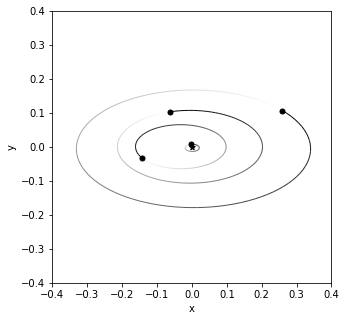

In [12]:
fig = rebound.OrbitPlot(sim)

In [13]:
A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, transittimes)[0]

/home/dinob/anaconda3/envs/exoplanets/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


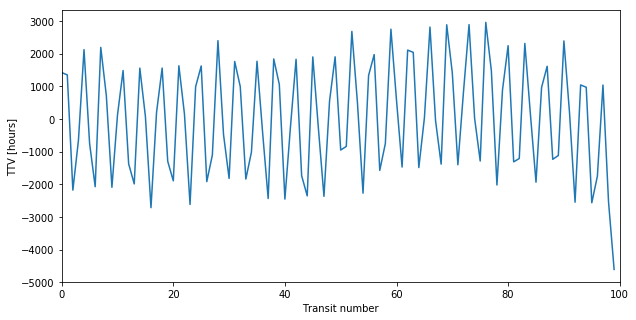

In [14]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlim([0,N])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")
plt.plot(range(N), (transittimes-m*np.array(range(N))-c)*(24.*365./2./np.pi));